
Generating Heatmap 1...


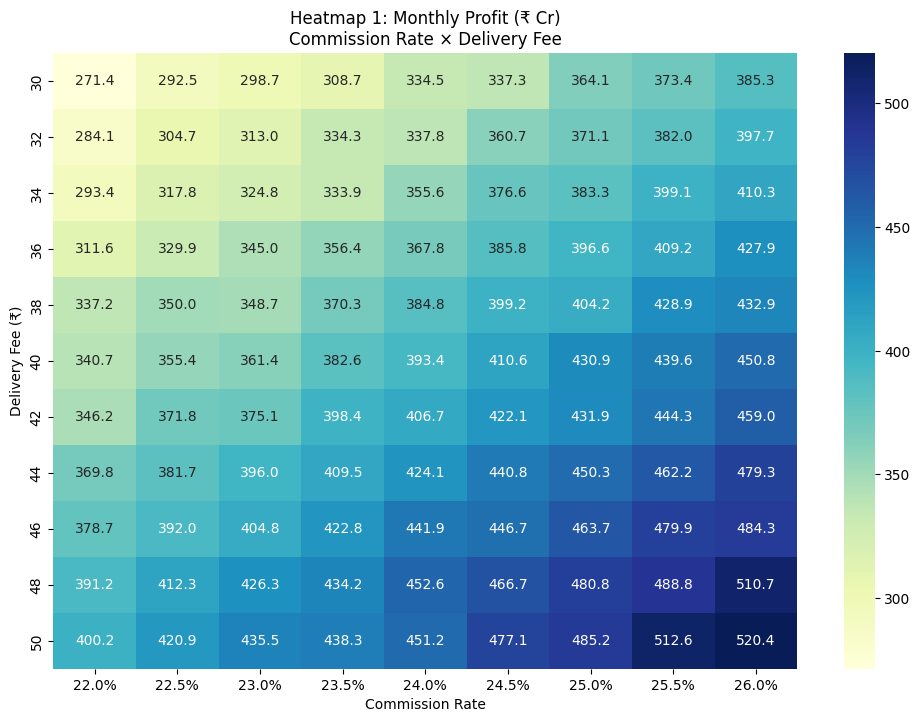


Generating Heatmap 2...


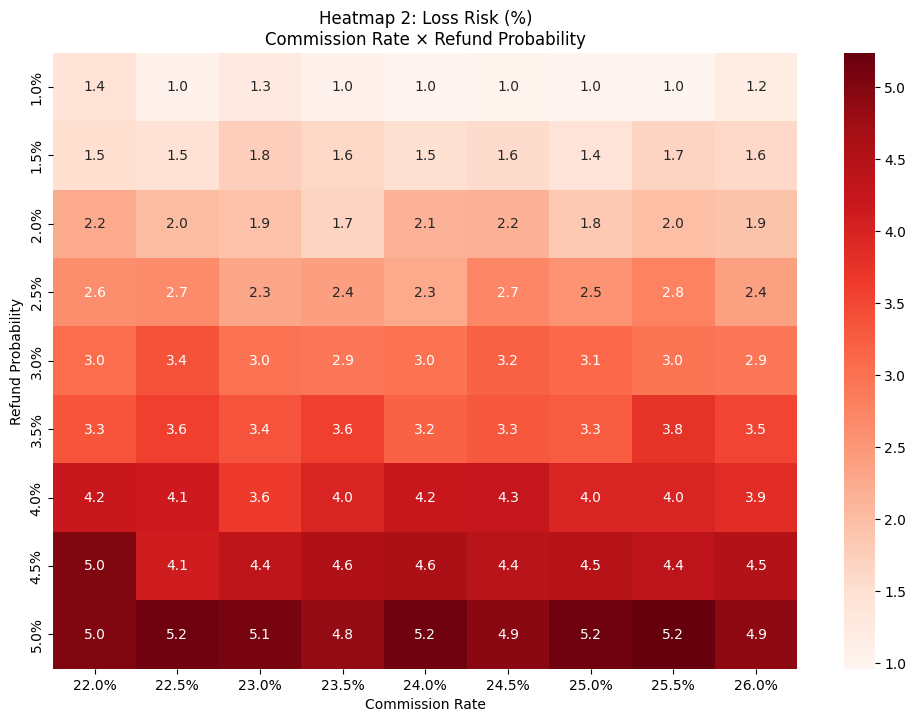

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# GLOBAL SETTINGS
# -------------------------------
SIMULATIONS = 10_000
BASE_MONTHLY_ORDERS = 66_000_000
np.random.seed(42)

# -------------------------------
# BASELINE PARAMETERS
# -------------------------------
BASE_PARAMS = {
    "AOV_MEAN": 428,
    "AOV_SD": 50,

    "COMMISSION_RATE": 0.225,
    "DELIVERY_FEE": 35,

    "RIDER_MEAN": 32,
    "RIDER_SD": 10,

    "PACK_MEAN": 12,
    "PACK_SD": 3,

    "MKT_MEAN": 20,
    "MKT_SD": 10,

    "GATEWAY_RATE": 0.024,
    "RETURN_PROB": 0.02
}

# -------------------------------
# MONTE CARLO SIMULATION ENGINE
# -------------------------------
def run_simulation(params, n_orders=SIMULATIONS):
    aov = np.random.normal(params["AOV_MEAN"], params["AOV_SD"], n_orders)
    rider_cost = np.random.normal(params["RIDER_MEAN"], params["RIDER_SD"], n_orders)
    packaging_cost = np.random.normal(params["PACK_MEAN"], params["PACK_SD"], n_orders)
    marketing_cost = np.random.normal(params["MKT_MEAN"], params["MKT_SD"], n_orders)

    gateway_fee = aov * params["GATEWAY_RATE"]
    refund_flag = np.random.binomial(1, params["RETURN_PROB"], n_orders)
    refund_loss = aov * refund_flag

    revenue = aov * params["COMMISSION_RATE"] + params["DELIVERY_FEE"]
    total_cost = rider_cost + packaging_cost + marketing_cost + gateway_fee + refund_loss

    profit = revenue - total_cost

    avg_profit = profit.mean()
    loss_prob = (profit < 0).mean() * 100

    return avg_profit, loss_prob


# =================================================================
#  HEATMAP 1: COMMISSION RATE × DELIVERY FEE → MONTHLY PROFIT
# =================================================================
commission_values = np.arange(0.22, 0.2601, 0.005)   # 22% → 26%
delivery_fees = np.arange(30, 51, 2)                 # ₹30 → ₹50

profit_matrix = []

print("\nGenerating Heatmap 1...")

for fee in delivery_fees:
    row = []
    for comm in commission_values:
        params = {**BASE_PARAMS,
                  "COMMISSION_RATE": comm,
                  "DELIVERY_FEE": fee}

        avg_profit, loss_risk = run_simulation(params)

        monthly_profit = avg_profit * BASE_MONTHLY_ORDERS
        row.append(monthly_profit / 1e7)   # Convert to ₹ Cr
    profit_matrix.append(row)

profit_df = pd.DataFrame(profit_matrix,
                         index=delivery_fees,
                         columns=[f"{c*100:.1f}%" for c in commission_values])

# -------------------------------
# PLOT HEATMAP 1
# -------------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(profit_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Heatmap 1: Monthly Profit (₹ Cr)\nCommission Rate × Delivery Fee")
plt.xlabel("Commission Rate")
plt.ylabel("Delivery Fee (₹)")
plt.show()


# =================================================================
#  HEATMAP 2: COMMISSION RATE × REFUND PROBABILITY → LOSS RISK
# =================================================================
refund_probs = np.arange(0.01, 0.0501, 0.005)        # 1% → 5%

risk_matrix = []

print("\nGenerating Heatmap 2...")

for refund in refund_probs:
    row = []
    for comm in commission_values:
        params = {**BASE_PARAMS,
                  "COMMISSION_RATE": comm,
                  "RETURN_PROB": refund}

        avg_profit, loss_risk = run_simulation(params)
        row.append(loss_risk)
    risk_matrix.append(row)

risk_df = pd.DataFrame(risk_matrix,
                       index=[f"{r*100:.1f}%" for r in refund_probs],
                       columns=[f"{c*100:.1f}%" for c in commission_values])

# -------------------------------
# PLOT HEATMAP 2
# -------------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(risk_df, annot=True, fmt=".1f", cmap="Reds")
plt.title("Heatmap 2: Loss Risk (%)\nCommission Rate × Refund Probability")
plt.xlabel("Commission Rate")
plt.ylabel("Refund Probability")
plt.show()
